# Movie Recommendation System Using Collaborative Filtering
This notebook demonstrates how to build a movie recommendation system using the **MovieLens 100K** dataset. We implement **User-Based**, **Item-Based**, and a **Hybrid User + Genre-Based Collaborative Filtering** model using cosine similarity and evaluate with Precision@5 and Recall@5.

## Step 1: Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')


## Step 2: Load Dataset

In [15]:
ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")

print("Ratings Sample:\n", ratings.head())
print("Movies Sample:\n", movies.head())


Ratings Sample:
    userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
Movies Sample:
    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


## Step 3: Create User-Item Matrix
We pivot the ratings dataframe to form a user-movie rating matrix. This matrix is the foundation for collaborative filtering.

In [16]:
pivot = ratings.pivot(index='movieId', columns='userId', values='rating').fillna(0)
user_matrix = pivot.T
item_matrix = pivot

print(f"User-matrix shape: {user_matrix.shape}, Item-matrix shape: {item_matrix.shape}")


User-matrix shape: (610, 9724), Item-matrix shape: (9724, 610)


In [17]:
# 3.1: Filter Cold-Start Users (Fewer than 10 ratings)
user_activity = ratings.groupby('userId').size()
active_users = user_activity[user_activity >= 10].index
filtered_user_matrix = user_matrix.loc[user_matrix.index.isin(active_users)]

print(f"Filtered user-matrix shape: {filtered_user_matrix.shape}")


Filtered user-matrix shape: (610, 9724)


In [18]:
# 3.2: Normalize Ratings (Mean-Centering)
user_means = filtered_user_matrix.replace(0, np.nan).mean(axis=1)
normalized_user_matrix = filtered_user_matrix.sub(user_means, axis=0).fillna(0)

print("Sample normalized ratings for one user:")
print(normalized_user_matrix.iloc[0].head())

Sample normalized ratings for one user:
movieId
1   -0.366379
2   -4.366379
3   -0.366379
4   -4.366379
5   -4.366379
Name: 1, dtype: float64


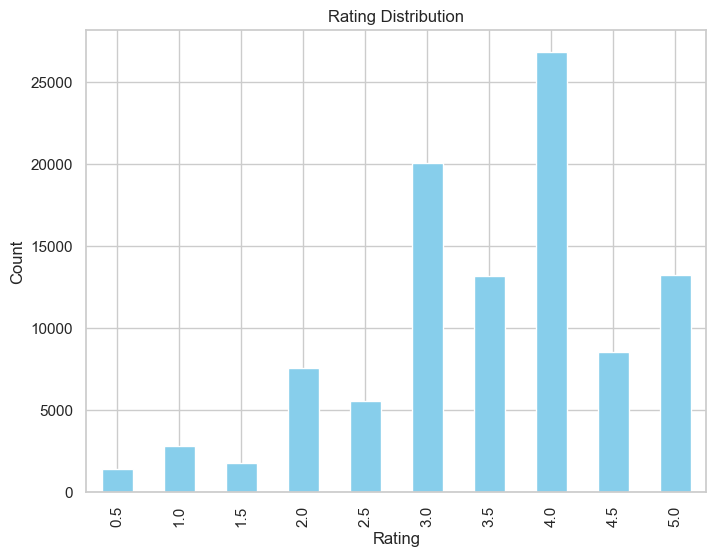

In [32]:
# Plot the distribution of ratings
plt.figure(figsize=(8, 6))
ratings['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.savefig("outputs/rating_distribution.png")
plt.show()


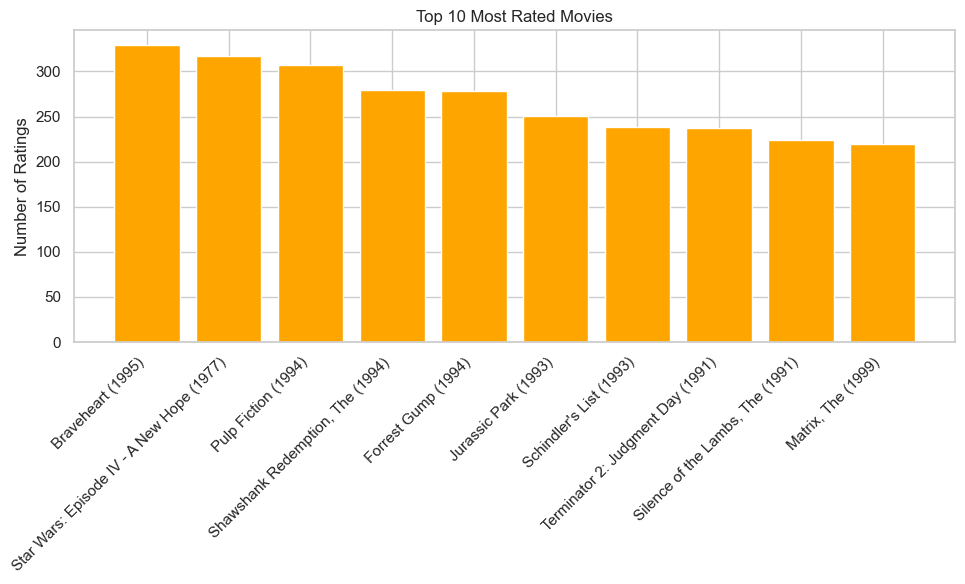

In [33]:
# Top 10 most rated movies
top_movies = ratings['movieId'].value_counts().head(10)
top_movies_titles = movies[movies['movieId'].isin(top_movies.index)]

plt.figure(figsize=(10, 6))
plt.bar(top_movies_titles['title'], top_movies.values, color='orange')
plt.title("Top 10 Most Rated Movies")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Ratings")
plt.tight_layout()
plt.savefig("outputs/popular_movies_barplot.png")
plt.show()


## Step 4: Visualize Data Sparsity and Distributions

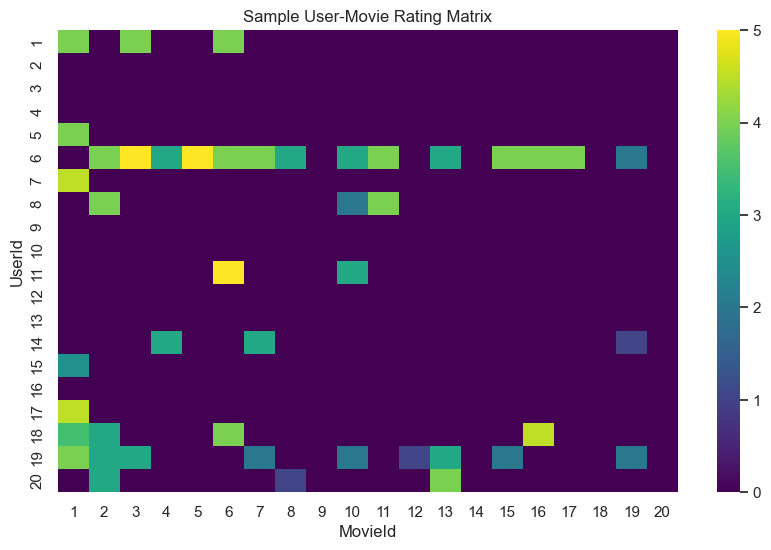

In [19]:
plt.figure(figsize=(10,6))
sns.heatmap(filtered_user_matrix.iloc[:20, :20], cmap='viridis')
plt.title("Sample User-Movie Rating Matrix")
plt.xlabel("MovieId")
plt.ylabel("UserId")
plt.show()


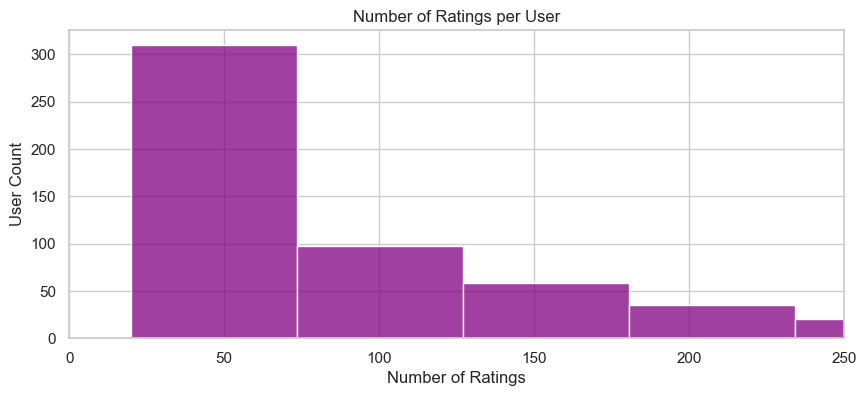

In [20]:
ratings_per_user = ratings.groupby('userId').size()
plt.figure(figsize=(10,4))
sns.histplot(ratings_per_user, bins=50, color='purple')
plt.title("Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("User Count")
plt.xlim(0, 250)
plt.show()

C:\Users\ramch\AppData\Local\Temp\ipykernel_9516\1767907160.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_rated.values, y=most_rated_movies['title'], palette='magma')


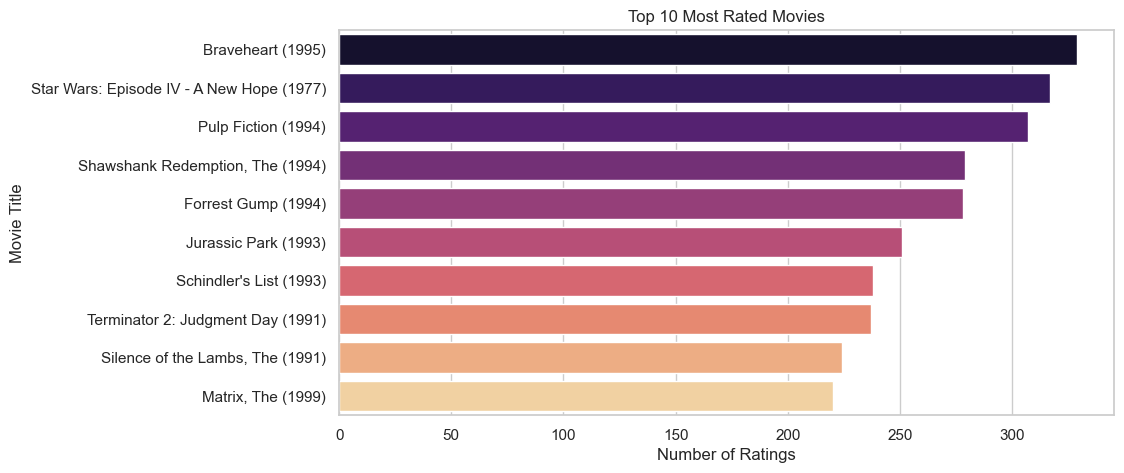

In [21]:
most_rated = ratings.groupby('movieId').size().sort_values(ascending=False).head(10)
most_rated_movies = movies[movies.movieId.isin(most_rated.index)]

plt.figure(figsize=(10,5))
sns.barplot(x=most_rated.values, y=most_rated_movies['title'], palette='magma')
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.show()

C:\Users\ramch\AppData\Local\Temp\ipykernel_9516\3545212674.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='Set2')


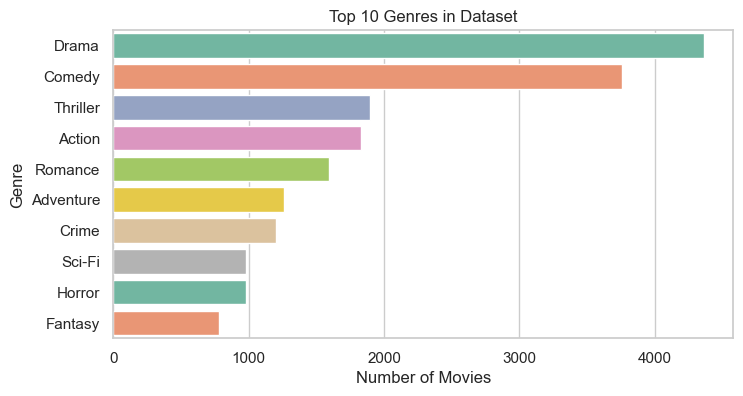

In [22]:
movies_expanded = movies.copy()
movies_expanded['genres'] = movies_expanded['genres'].str.split('|')
genre_counts = movies_expanded['genres'].explode().value_counts().head(10)

plt.figure(figsize=(8,4))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='Set2')
plt.title("Top 10 Genres in Dataset")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.show()

## Step 5: User Similarity Matrix
We calculate cosine similarity between users to identify how similar their preferences are.

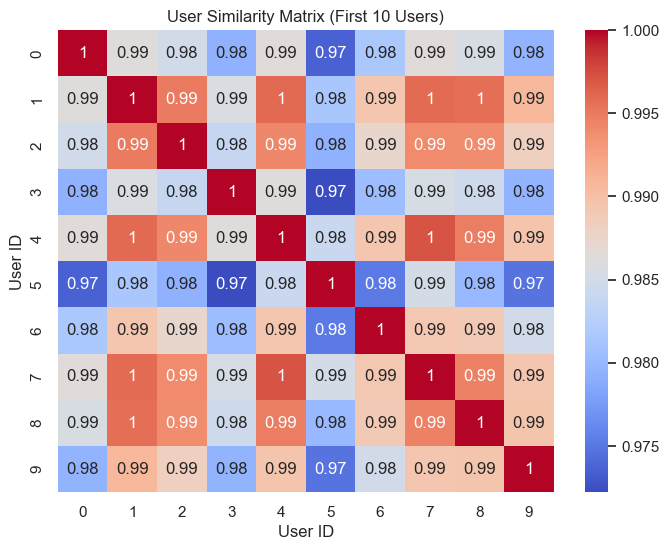

In [31]:
user_sim = cosine_similarity(normalized_user_matrix)
plt.figure(figsize=(8,6))
sns.heatmap(user_sim[:10, :10], cmap='coolwarm', annot=True)
plt.title("User Similarity Matrix (First 10 Users)")
plt.xlabel("User ID")
plt.ylabel("User ID")
plt.show()


## Step 6: User-Based Collaborative Filtering

In [24]:
user_knn = NearestNeighbors(metric='cosine', algorithm='brute')
user_knn.fit(normalized_user_matrix.values)

target_user = 5
distances, indices = user_knn.kneighbors([normalized_user_matrix.loc[target_user].values], n_neighbors=6)
neighbors = [normalized_user_matrix.index[i] for i in indices.flatten()[1:]]

print(f"Top similar users to User {target_user}: {neighbors}")

# Weighted ratings from neighbors
similarities = 1 - distances.flatten()[1:]
ratings_neighbors = normalized_user_matrix.loc[neighbors]
weighted_scores = np.dot(similarities, ratings_neighbors.values) / (np.sum(similarities) + 1e-8)
predicted_ratings = pd.Series(weighted_scores, index=normalized_user_matrix.columns)

rated_movies = set(ratings[ratings.userId == target_user].movieId)
recommendations_user = predicted_ratings.drop(labels=list(rated_movies), errors='ignore')
top5_user = recommendations_user.sort_values(ascending=False).head(5)

print("Top 5 User-based Recommendations:")
print(movies[movies.movieId.isin(top5_user.index)][['movieId', 'title']])


Top similar users to User 5: [np.int64(565), np.int64(145), np.int64(394), np.int64(142), np.int64(507)]
Top 5 User-based Recommendations:
     movieId                              title
43        47        Seven (a.k.a. Se7en) (1995)
138      165  Die Hard: With a Vengeance (1995)
297      339     While You Were Sleeping (1995)
314      356                Forrest Gump (1994)
334      377                       Speed (1994)


## Step 7: Item-Based Collaborative Filtering

In [25]:
item_knn = NearestNeighbors(metric='cosine', algorithm='brute')
item_knn.fit(item_matrix.values)

user_ratings = ratings[(ratings.userId == target_user) & (ratings.rating >= 4)]
liked_movies = list(user_ratings.movieId)

similar_movies = set()
for movie_id in liked_movies:
    if movie_id in item_matrix.index:
        dist, idx = item_knn.kneighbors([item_matrix.loc[movie_id].values], n_neighbors=4)
        for i in idx.flatten()[1:]:
            similar_id = item_matrix.index[i]
            similar_movies.add(similar_id)

similar_movies -= set(liked_movies)
top_similar_titles = movies[movies.movieId.isin(list(similar_movies))][['movieId', 'title']].head(5)

print("Top 5 Item-based Recommendations:")
print(top_similar_titles)


Top 5 Item-based Recommendations:
     movieId                         title
13        14                  Nixon (1995)
16        17  Sense and Sensibility (1995)
24        25      Leaving Las Vegas (1995)
43        47   Seven (a.k.a. Se7en) (1995)
164      194                  Smoke (1995)


## Step 8: Hybrid Filtering (User-Based + Genre-Based)

In [26]:
user_liked = ratings[(ratings.userId == target_user) & (ratings.rating >= 4)].merge(movies_expanded, on='movieId')
all_genres = user_liked['genres'].explode().value_counts()
top_genres = all_genres.head(2).index.tolist()
print(f"Top genres preferred by user {target_user}: {top_genres}")

hybrid_candidates = movies[movies.movieId.isin(top5_user.index)].copy()
hybrid_candidates['genres'] = hybrid_candidates['genres'].str.split('|')
hybrid_filtered = hybrid_candidates[hybrid_candidates['genres'].apply(lambda g: any(tg in g for tg in top_genres))]

print("Hybrid Recommendations (User + Genre-Based):")
print(hybrid_filtered[['movieId', 'title']])


Top genres preferred by user 5: ['Drama', 'Crime']
Hybrid Recommendations (User + Genre-Based):
     movieId                              title
138      165  Die Hard: With a Vengeance (1995)
314      356                Forrest Gump (1994)


## Step 9: Evaluation Metrics
We compute Precision@5 and Recall@5 to measure how relevant the recommendations are.

In [27]:
from tqdm import tqdm

def precision_recall_at_k(recommended_ids, relevant_ids, k=5):
    recommended_at_k = recommended_ids[:k]
    relevant_set = set(relevant_ids)
    true_positives = len([movie for movie in recommended_at_k if movie in relevant_set])
    precision = true_positives / k
    recall = true_positives / len(relevant_set) if relevant_set else 0
    return precision, recall

# Users with at least 6 liked items
active_eval_users = ratings[ratings.rating >= 4].groupby('userId').filter(lambda x: len(x) >= 6)['userId'].unique()
print(f"Number of users eligible for evaluation: {len(active_eval_users)}")

eval_users = np.random.choice(active_eval_users, size=50, replace=False)

precision_list = []
recall_list = []

for user in tqdm(eval_users, desc="Evaluating users"):
    liked = ratings[(ratings.userId == user) & (ratings.rating >= 4)]
    test_holdout = liked.sample(n=1, random_state=42)
    test_movie_id = test_holdout.movieId.iloc[0]
    rated_movies = set(liked.movieId) - {test_movie_id}
    
    if user in normalized_user_matrix.index:
        distances, indices = user_knn.kneighbors([normalized_user_matrix.loc[user].values], n_neighbors=6)
        neighbors = [normalized_user_matrix.index[i] for i in indices.flatten() if normalized_user_matrix.index[i] != user]

        similarities = 1 - distances.flatten()[1:]
        ratings_neighbors = normalized_user_matrix.loc[neighbors]
        weighted_scores = np.dot(similarities, ratings_neighbors.values) / (np.sum(similarities) + 1e-8)

        predicted_ratings = pd.Series(weighted_scores, index=normalized_user_matrix.columns)
        predicted_ratings = predicted_ratings.drop(labels=list(rated_movies), errors='ignore')

        top5_ids = predicted_ratings.sort_values(ascending=False).head(5).index.tolist()

        precision, recall = precision_recall_at_k(top5_ids, [test_movie_id], k=5)
        precision_list.append(precision)
        recall_list.append(recall)

avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)

print(f"\nAverage Precision@5 over {len(precision_list)} users: {avg_precision:.3f}")
print(f"Average Recall@5 over {len(recall_list)} users: {avg_recall:.3f}")


Number of users eligible for evaluation: 599


Evaluating users: 100%|██████████| 50/50 [00:04<00:00, 11.47it/s]


Average Precision@5 over 50 users: 0.040
Average Recall@5 over 50 users: 0.200


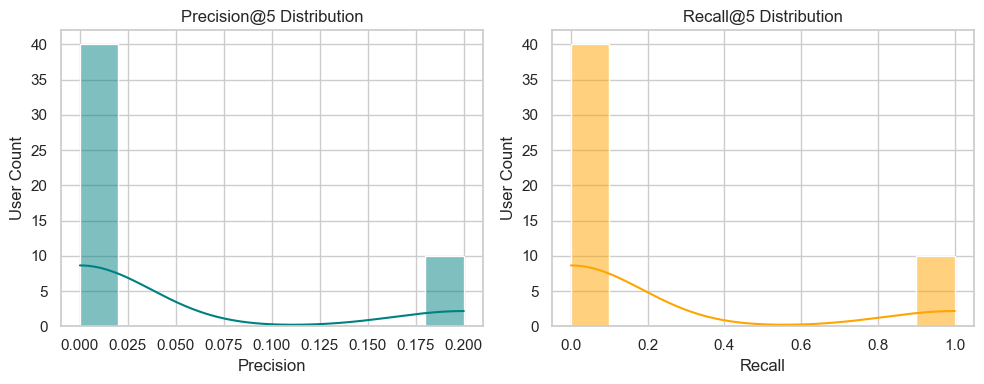

In [28]:
# Plotting precision and recall distribution across evaluated users
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(precision_list, bins=10, kde=True, color='teal')
plt.title("Precision@5 Distribution")
plt.xlabel("Precision")
plt.ylabel("User Count")

plt.subplot(1,2,2)
sns.histplot(recall_list, bins=10, kde=True, color='orange')
plt.title("Recall@5 Distribution")
plt.xlabel("Recall")
plt.ylabel("User Count")

plt.tight_layout()
plt.show()


## Step 10: Visualizations

C:\Users\ramch\AppData\Local\Temp\ipykernel_9516\3686733727.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ratings_pred, y=labels, palette='coolwarm')


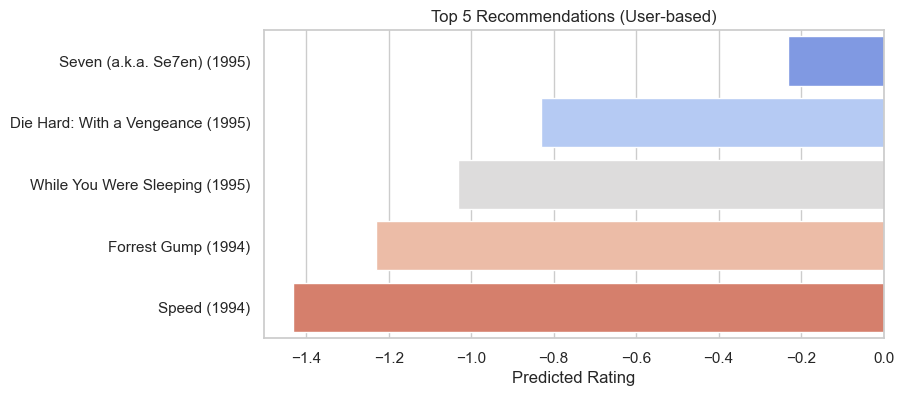

In [46]:
plt.figure(figsize=(8,4))
labels = movies[movies.movieId.isin(top5_user.index)].title.tolist()
ratings_pred = top5_user.values
sns.barplot(x=ratings_pred, y=labels, palette='coolwarm')
plt.xlabel("Predicted Rating")
plt.title("Top 5 Recommendations (User-based)")
plt.savefig("outputs/Top 5 reccomendations(user-base).png")
plt.show()
